<a href="https://colab.research.google.com/github/bo-cheng-tsai/homework/blob/main/week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
<ipython-input-28-aa10090a8297>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Predicted'] = forecast


ARIMA 模型的 RMSE: 33.05983511791151


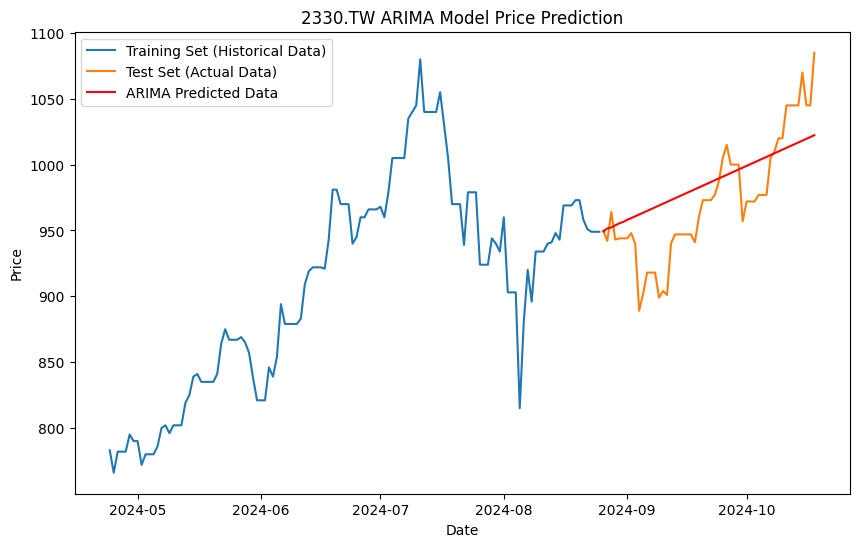

In [28]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np
import datetime as dt
from matplotlib import font_manager as fm

# 輸入股票代號
stock_id = "2330.TW"
end = dt.date.today()
start = end - dt.timedelta(days=180)

# 下載股票資料
df = yf.download(stock_id, start=start, end=end)
df = df[['Close']]

# 設置日期頻率
df.index = pd.to_datetime(df.index)
df = df.asfreq('D')
df = df.ffill()  # 使用前向填充

# 訓練和測試集拆分
train_size = int(len(df) * 0.7)
train, test = df[:train_size], df[train_size:]

# 構建 ARIMA 模型
model = ARIMA(train['Close'], order=(4, 2, 2))
model_fit = model.fit()

# 預測測試集
forecast = model_fit.forecast(steps=len(test))
test.loc[:, 'Predicted'] = forecast

# 評估模型性能 (RMSE)
rmse = np.sqrt(mean_squared_error(test['Close'], test['Predicted']))
print(f'ARIMA 模型的 RMSE: {rmse}')

plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(train['Close'], label='Training Set (Historical Data)')
plt.plot(test['Close'], label='Test Set (Actual Data)')
plt.plot(test.index, forecast, label='ARIMA Predicted Data', color='red')
plt.title(f'{stock_id} ARIMA Model Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed
<ipython-input-33-69931890d054>:19: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['Position'][df['20_MA'] > df['50_MA']] = 1  # 短期均線上穿長期均線，買入
<ipython-input-33-69931890d

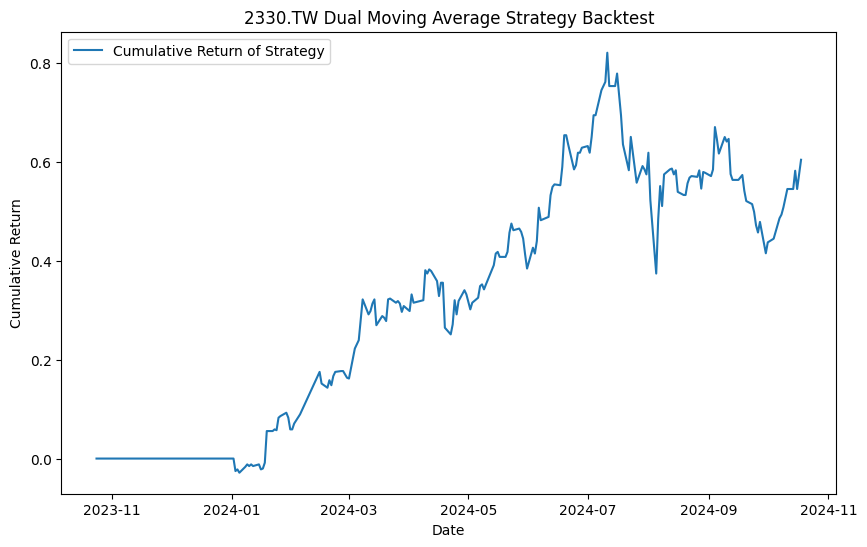

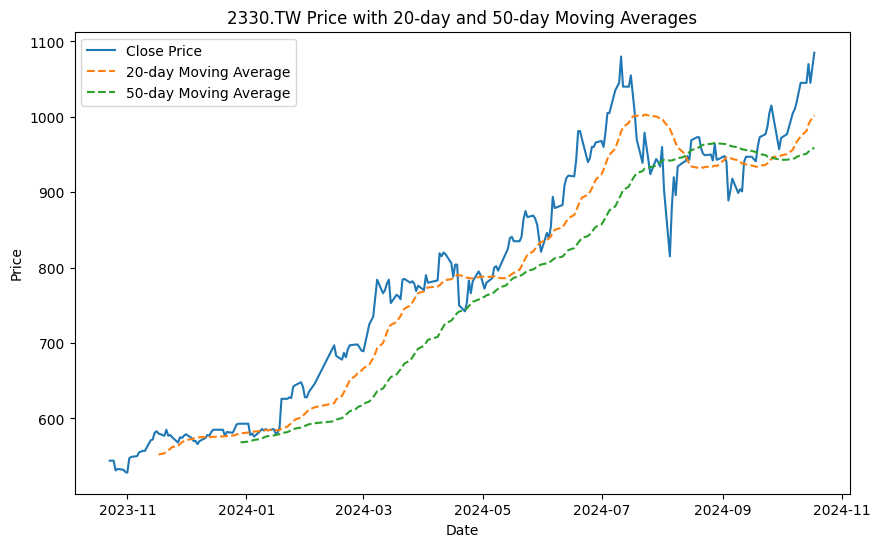

In [33]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. 下載股票數據
stock_id = "2330.TW"  # TSMC stock (台積電)
end = pd.to_datetime('today')
start = end - pd.DateOffset(days=365)  # 1年資料
df = yf.download(stock_id, start=start, end=end)

# 2. 計算短期和長期移動平均線
df['20_MA'] = df['Close'].rolling(window=20).mean()  # 20天短期移動平均線
df['50_MA'] = df['Close'].rolling(window=50).mean()  # 50天長期移動平均線

# 3. 定義雙均線策略
def dual_moving_average_strategy(df):
    df['Position'] = 0  # 初始化持倉
    df['Position'][df['20_MA'] > df['50_MA']] = 1  # 短期均線上穿長期均線，買入
    df['Position'][df['20_MA'] < df['50_MA']] = -1  # 短期均線下穿長期均線，賣出
    return df

df = dual_moving_average_strategy(df)

# 4. 回測策略績效
def backtest(df):
    df['Return'] = df['Close'].pct_change() * df['Position'].shift(1)  # 計算日回報率
    df['Cumulative Return'] = (1 + df['Return']).cumprod() - 1  # 累積回報率
    return df

df = backtest(df)

plt.rcParams['font.sans-serif'] = ['DejaVu Sans']  # 使用 DejaVu Sans 字體，適合大部分系統
plt.rcParams['axes.unicode_minus'] = False  # 解決負號顯示問題

# 5. 可視化策略績效（累積回報率圖）
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Cumulative Return'], label='Cumulative Return of Strategy')
plt.title(f'{stock_id} Dual Moving Average Strategy Backtest')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()

# 6. 股票價格與移動均線
plt.figure(figsize=(10, 6))
plt.plot(df.index, df['Close'], label='Close Price')
plt.plot(df.index, df['20_MA'], label='20-day Moving Average', linestyle='--')
plt.plot(df.index, df['50_MA'], label='50-day Moving Average', linestyle='--')
plt.title(f'{stock_id} Price with 20-day and 50-day Moving Averages')  # 確保標題設置在這裡
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()